**1. Draw an example (of your own invention) of a partition of two-dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions R1, R2, ..., the cutpoints t1, t2, ..., and so forth.**

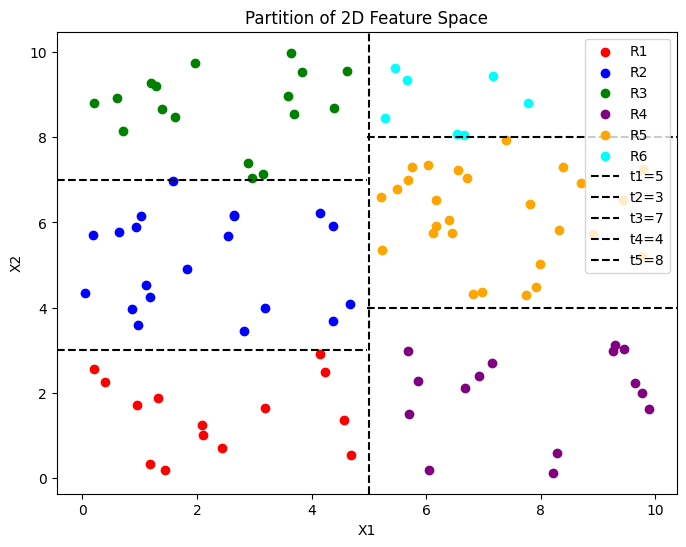

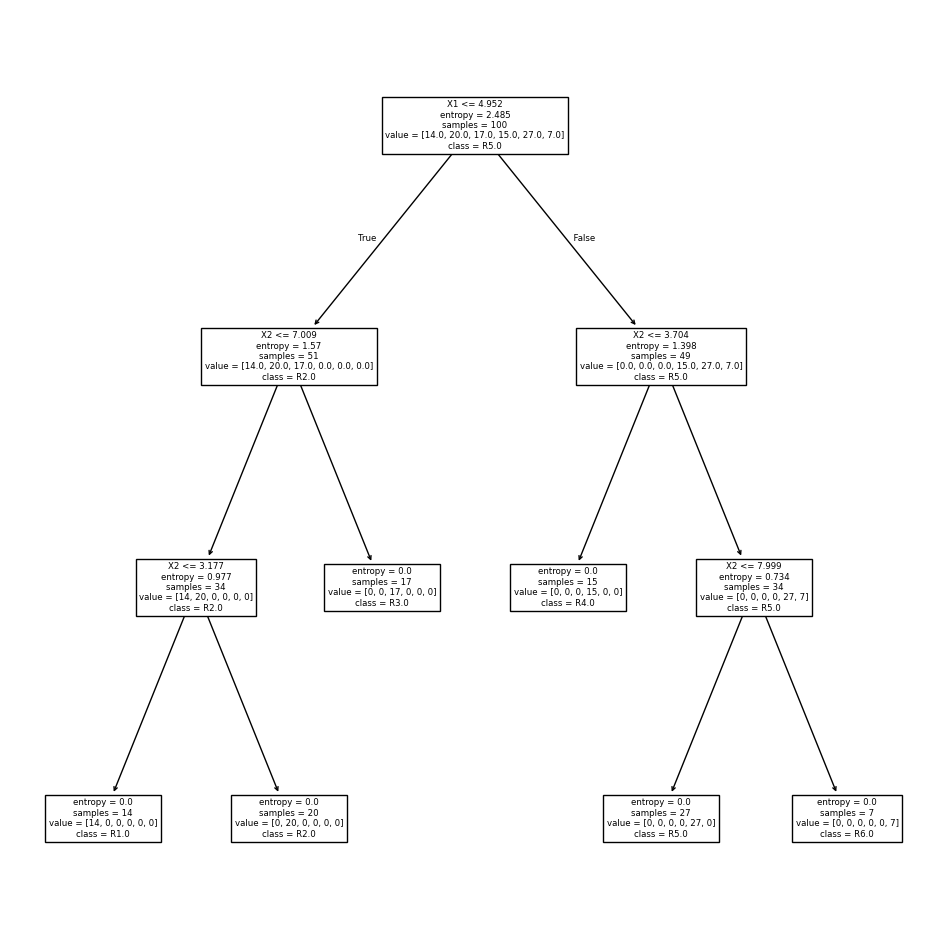

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree, export_text
from ISLP.models import ModelSpec as MS

np.random.seed(0)
n = 100
X1 = np.random.uniform(0, 10, n)
X2 = np.random.uniform(0, 10, n)
y = np.zeros(n)

for i in range(n):
    if X1[i] <= 5:
        if X2[i] <= 3:
            y[i] = 1  # R1
        elif X2[i] <= 7:
            y[i] = 2  # R2
        else:
            y[i] = 3  # R3
    else:
        if X2[i] <= 4:
            y[i] = 4  # R4
        elif X2[i] <= 8:
            y[i] = 5  # R5
        else:
            y[i] = 6  # R6

df = pd.DataFrame({'X1': X1, 'X2': X2, 'Region': y})

colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']
plt.figure(figsize=(8,6))
for region in range(1,7):
    subset = df[df['Region']==region]
    plt.scatter(subset['X1'], subset['X2'], color=colors[region-1], label=f'R{region}')
    
plt.axvline(x=5, color='black', linestyle='--', label='t1=5')
plt.axhline(y=3, xmin=0, xmax=0.5, color='black', linestyle='--', label='t2=3')
plt.axhline(y=7, xmin=0, xmax=0.5, color='black', linestyle='--', label='t3=7')
plt.axhline(y=4, xmin=0.5, xmax=1, color='black', linestyle='--', label='t4=4')
plt.axhline(y=8, xmin=0.5, xmax=1, color='black', linestyle='--', label='t5=8')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Partition of 2D Feature Space')
plt.legend()
plt.show()

X = ['X1','X2']
y_labels = df['Region']

model = MS(X, intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

clf = DTC(criterion='entropy',
          max_depth=6,
          random_state=0)        
clf.fit(X, y_labels)

class_names = [f'R{i}' for i in sorted(df['Region'].unique())]

ax = plt.subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          class_names=class_names,
          ax=ax);

**2. It is mentioned in Section 8.2.3 that boosting using depth-one trees (or stumps) leads to an additive model: that is, a model of the form:**

$$
f(X) = \sum_{j=1}^p f_j(X_j)
$$

**Explain why this is the case. You can begin with (8.12) in Algorithm 8.2.**

We know that the boosted model after $B$ iterations is

$$
\hat{f}(x) = \sum_{b=1}^B \lambda \hat{f}^b(x).
$$

For an individual weak learner $\hat{f}^b$ with depth $d=1$, the stump depends on only a single predictor. Thus, each $\hat{f}^b$ can be written as a function of the form $\hat{f}^b_j(X_j)$ for some predictor $j$.

Now, across many iterations $B$, different predictors will be selected at different steps. Let $\hat{f}^b_j$ denote the stump at iteration $b$ that depends on the $j^{th}$ predictor. If we collect all the stumps that involve the same predictor $X_j$, we can sum them together to form a function $f_j(X_j)$.

Formally,

$$
\hat{f}(x) = \sum_{b=1}^B \lambda \hat{f}^b(x)
           = \sum_{j=1}^p \sum_{b : j(b)=j} \lambda \hat{f}^b_j(X_j).
$$

Defining

$$
f_j(X_j) = \sum_{b : j(b)=j} \lambda \hat{f}^b_j(X_j),
$$

we obtain the additive representation

$$
f(X) = \sum_{j=1}^p f_j(X_j).
$$

**3. Consider the Gini index, classification error, and entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of $\hat{p}_{m1}$. The x-axis should display $\hat{p}_{m1}$, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and entropy.**

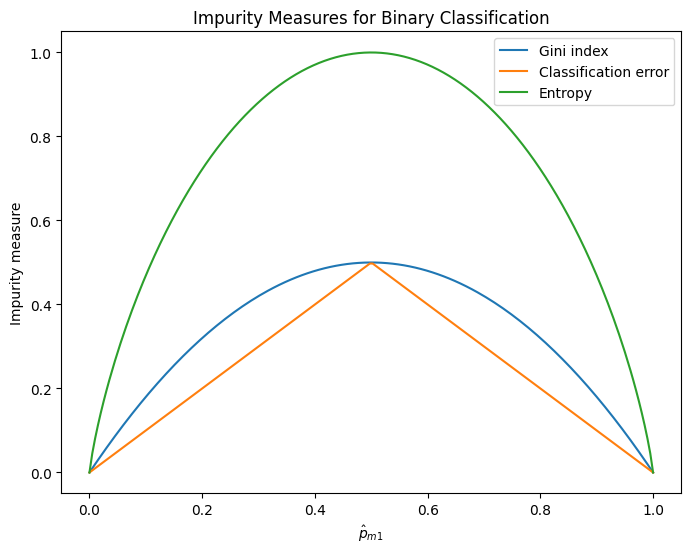

In [18]:
pm1 = np.linspace(0, 1, 200)
pm2 = 1 - pm1

error = 1 - np.maximum(pm1, pm2)
gini = pm1 * (1 - pm1) + pm2 * (1 - pm2)
entropy = -(pm1 * np.log2(np.where(pm1 > 0, pm1, 1)) + pm2 * np.log2(np.where(pm2 > 0, pm2, 1)))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(pm1, gini, label="Gini index")
ax.plot(pm1, error, label="Classification error")
ax.plot(pm1, entropy, label="Entropy")

ax.set_xlabel(r"$\hat{p}_{m1}$")
ax.set_ylabel("Impurity measure")
ax.set_title("Impurity Measures for Binary Classification")
ax.legend()
plt.show()

The resulting graph shows that all three impurity measures, classification error, Gini index, and entropy, are symmetric around $\hat{p}_{m1}=0.5$, reaching their maximum when the classes are equally likely and dropping to zero when one class has probability 1, meaning the node is pure. Classification error forms a piecewise linear “V” shape with a maximum of 0.5, making it relatively insensitive to small changes in class probabilities. The Gini index has a smooth quadratic shape, also peaking at 0.5, and is more responsive than classification error. Entropy has the smoothest, most gradual curve, reaching a maximum of 1 (in bits, with log base 2), and is highly sensitive to probability changes near the edges. This behavior explains why Gini and entropy are typically preferred as splitting criteria in decision trees, since they better capture differences in impurity compared to classification error.

**4. This question relates to the plots in Figure 8.14.**

**(a) Sketch the tree corresponding to the partition of the predictor space illustrated in the left-hand panel of Figure 8.14. The numbers inside the boxes indicate the mean of Y within each region.**

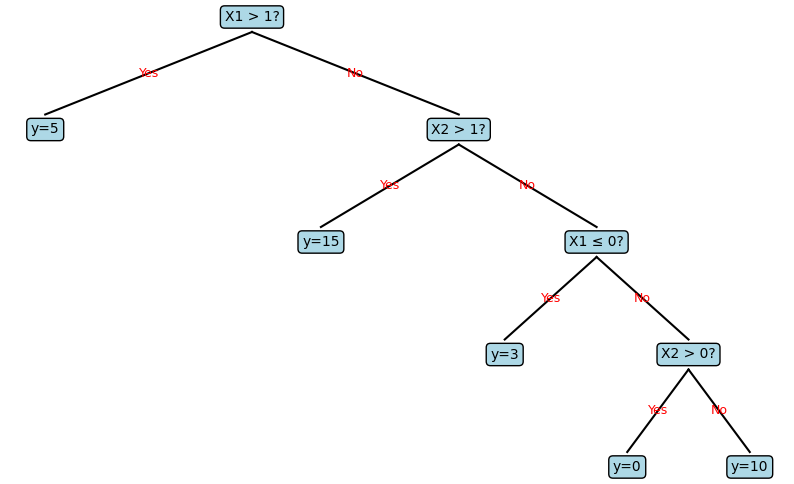

In [66]:
import matplotlib.pyplot as plt

tree = {
    "X1 > 1?": {
        "Yes": "y=5",
        "No": {
            "X2 > 1?": {
                "Yes": "y=15",
                "No": {
                    "X1 ≤ 0?": {
                        "Yes": "y=3",
                        "No": {
                            "X2 > 0?": {
                                "Yes": "y=0",
                                "No": "y=10"
                            }
                        }
                    }
                }
            }
        }
    }
}

def plot_tree(node, x=0.5, y=1.0, dx=0.2, dy=0.15, ax=None, parent=None, edge_label=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))
        ax.axis("off")
    
    ax.text(x, y, node if isinstance(node, str) else list(node.keys())[0],
            ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="k"))
    
    if parent is not None:
        ax.plot([parent[0], x], [parent[1]-0.02, y+0.02], "k-")
        if edge_label is not None:
            ax.text((parent[0]+x)/2, (parent[1]+y)/2, edge_label,
                    ha="center", va="center", fontsize=9, color="red")
    
    if isinstance(node, dict):
        key = list(node.keys())[0]
        children = node[key]
        n = len(children)
        for i, (branch, child) in enumerate(children.items()):
            child_x = x - dx*(n-1)/2 + i*dx
            child_y = y - dy
            plot_tree(child, x=child_x, y=child_y, dx=dx/1.5, dy=dy, ax=ax,
                      parent=(x, y), edge_label=branch)
    
    return ax

ax = plot_tree(tree)
plt.show()


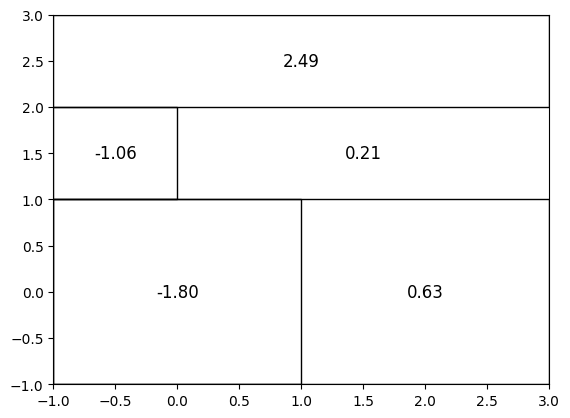

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()

rect1 = patches.Rectangle((-1, -1), 4, 2, fill=False)
rect2 = patches.Rectangle((-1, 2), 4, 1, fill=False)
rect3 = patches.Rectangle((-1, -1), 2, 2, fill=False)
rect4 = patches.Rectangle((-1, 1), 1, 1, fill=False)

ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)

ax.text(0, 0, '-1.80', ha='center', va='center', fontsize=12)
ax.text(2, 0, '0.63', ha='center', va='center', fontsize=12)
ax.text(1, 2.5, '2.49', ha='center', va='center', fontsize=12)
ax.text(-0.5, 1.5, '-1.06', ha='center', va='center', fontsize=12)
ax.text(1.5, 1.5, '0.21', ha='center', va='center', fontsize=12)

ax.set_xlim(-1, 3)
ax.set_ylim(-1, 3)

plt.show()

**5. Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X): 0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, and 0.75. There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?** 

Assuming that $P(\text{Class is Red} | X) > 0.5$ indicates that $X$ is classified as red, the majority vote approach considers each of the ten predictions individually. Since six of these predictions exceed 0.5, the majority vote assigns $X$ to the red class. In contrast, the second approach computes the average of the ten probabilities, which is 0.45. Because this average falls below 0.5, the probability-based method predicts that $X$ is not red.

**6. Provide a detailed explanation of the algorithm that is used to fit a regression tree.**

The algorithm for fitting a regression tree begins with **recursive binary splitting**, a top-down procedure that partitions the feature space into distinct regions. At each step, the algorithm considers all possible splits across all predictors and chooses the split that minimizes the sum of squared errors within the resulting regions. This process continues recursively, producing a large initial tree, often denoted as $T_0$. To prevent overfitting, a stopping criterion is applied, such as a minimum number of observations required in a terminal node.

Once the full tree is grown, the next step is **cost-complexity pruning**. This involves generating a sequence of subtrees by penalizing tree complexity through a tuning parameter $\alpha$, which controls the trade-off between tree size and fit. For each candidate subtree, a cost-complexity function is computed, combining the sum of squared errors and a penalty proportional to the number of terminal nodes. Cross-validation is then used to evaluate these subtrees and select the optimal $\alpha$, corresponding to the subtree with the lowest prediction error. The resulting pruned tree balances accuracy and interpretability, avoiding the overfitting that can occur with the fully grown tree.